In [1]:
import pandas as pd

"""we want to read in the 3 datasets and merge them to keep the following columns:
    raceId, milliseconds, circuitId, name_y
"""

mergedData = (
    pd.read_csv("pitStops.csv", encoding="ISO-8859-1")
    .merge(pd.read_csv("races.csv", encoding="ISO-8859-1"), on="raceId")
    .merge(pd.read_csv("circuits.csv", encoding="ISO-8859-1"), on="circuitId")
)

mergedData = mergedData[["raceId", "milliseconds", "circuitId", "name_y", "time_x"]]

<Axes: xlabel='circuitId'>

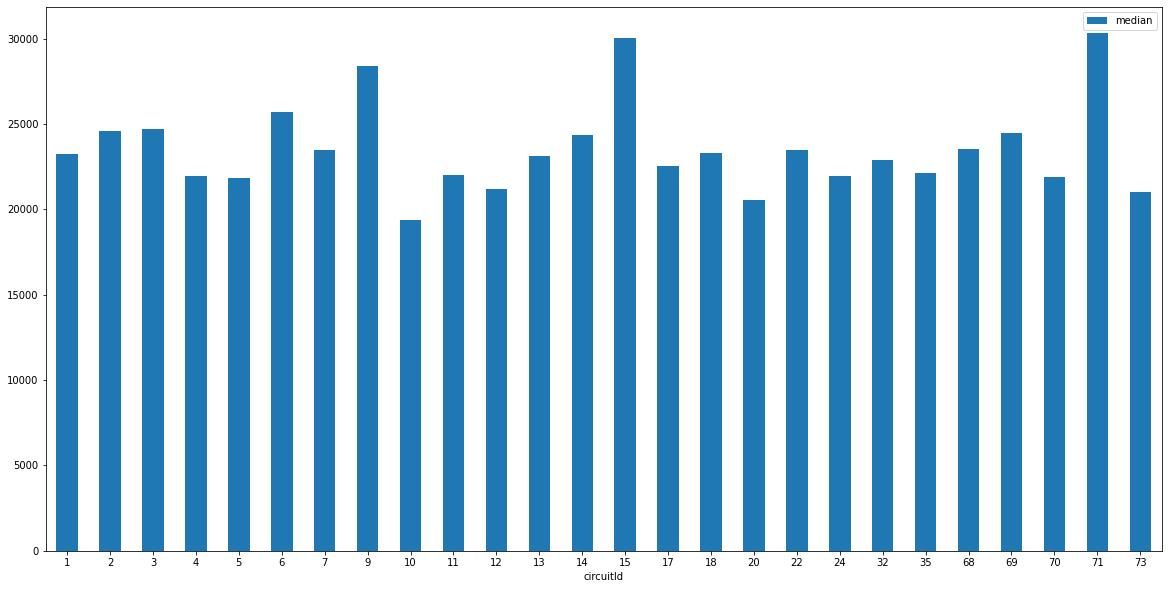

In [2]:
import sys
#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt

groupedMed = mergedData.groupby('circuitId')['milliseconds'].agg(['median']).reset_index()

groupedMed.plot.bar(x='circuitId', y='median', rot=0, figsize=(20,10))

<Axes: xlabel='circuitId'>

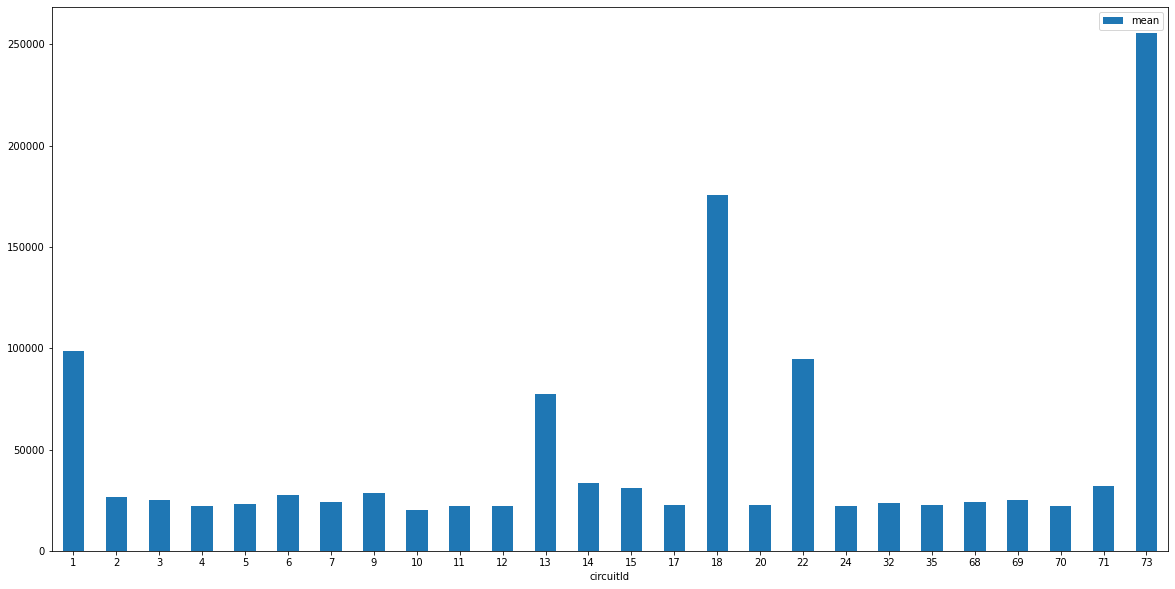

In [3]:
groupedMean = mergedData.groupby('circuitId')['milliseconds'].agg(['mean']).reset_index()

groupedMean.plot.bar(x='circuitId', y='mean', rot=0, figsize=(20,10))

<Axes: xlabel='circuitId'>

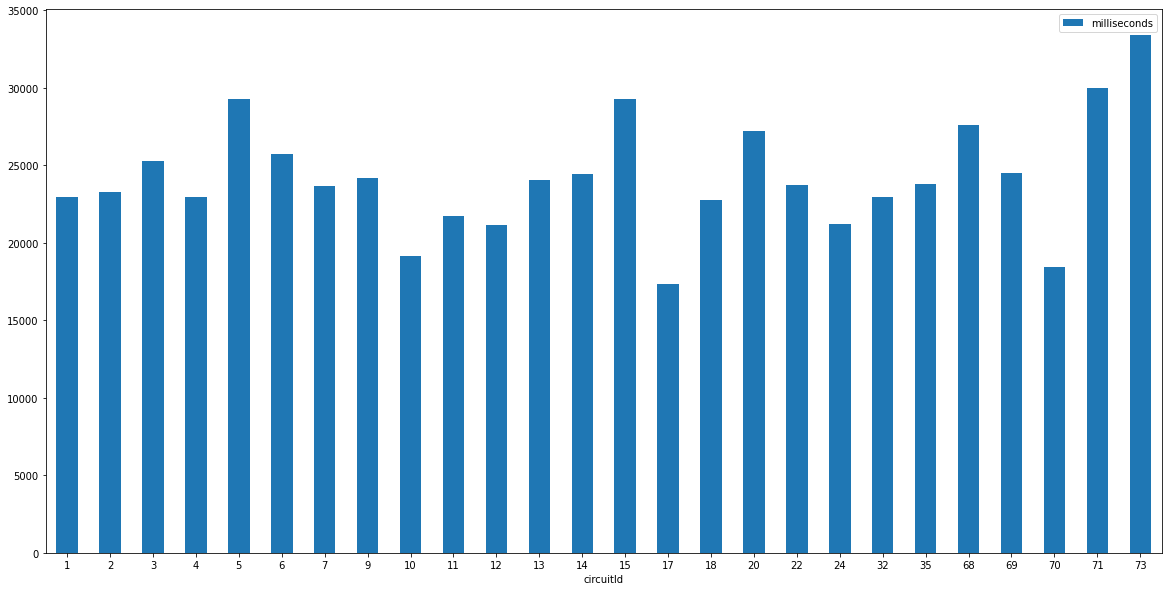

In [4]:
groupedMode = mergedData.groupby('circuitId')['milliseconds'].agg(lambda x: x.value_counts().index[0]).reset_index()

groupedMode.plot.bar(x='circuitId', y='milliseconds', rot=0, figsize=(20,10))

In [5]:
# Group by 'circuitId' and calculate mean and std
grouped = mergedData.groupby('circuitId')['milliseconds'].agg(['mean', 'std']).reset_index()

# Merge the grouped data with mergedData
mergedData = mergedData.merge(grouped, on='circuitId')

# Define a function to remove outliers
def remove_outliers(row):
    mean = row['mean']
    std = row['std']
    if mean - 3 * std <= row['milliseconds'] <= mean + 3 * std:
        return True
    return False

# Apply the remove_outliers function to filter rows
mergedData = mergedData[mergedData.apply(remove_outliers, axis=1)]

# Drop 'mean' and 'std' columns
mergedData = mergedData.drop(['mean', 'std'], axis=1)

In [6]:
condition1 = (mergedData['raceId'] == 967) & (mergedData['time_x'] > '14:42:00') & (mergedData['time_x'] < '15:25:00')
condition2 = (mergedData['raceId'] == 967) & (mergedData['time_x'] > '15:37:00') & (mergedData['time_x'] < '16:08:00')
conditon3 = (mergedData['raceId'] == 976) & (mergedData['time_x'] > '17:40:00') & (mergedData['time_x'] < '18:30:00')

removedRedFlagData73 = mergedData.drop(mergedData[condition1 | condition2].index)

store73 = removedRedFlagData73[removedRedFlagData73['raceId'] == 967] 

#get the mean of store73
store73['milliseconds'].mean()

removedRedFlagData18 = mergedData.drop(mergedData[conditon3].index)

store18 = removedRedFlagData18[removedRedFlagData18['raceId'] == 976]

store18['milliseconds'].mean()

groupedMean = mergedData.groupby('circuitId')['milliseconds'].agg(['mean']).reset_index()

groupedMean.loc[groupedMean['circuitId'] == 73, 'mean'] = store73['milliseconds'].mean()
groupedMean.loc[groupedMean['circuitId'] == 18, 'mean'] = store18['milliseconds'].mean()



In [7]:
finalData = mergedData.drop(mergedData[condition1 | condition2 | conditon3].index)

In [8]:
import pandas as pd
from sklearn.tree import DecisionTreeRegressor

"""
    we needed to use a decision tree to predict the average pit stop time for each track
    we used the raceId as the feature and the milliseconds as the target variable
    we used the circuitId as the groupby variable
    each track had its own model and predictions, as no track affects another
    we then calculated the average for each track and stored it in a dictionary
"""

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Group data by 'circuitId' and initialize dictionaries
groups = finalData.groupby('circuitId')
track_random_forest_models = {}
track_averages_random_forest = {}

# Iterate through groups
for circuit_id, group_data in groups:
    X = group_data[['raceId']]
    y = group_data['milliseconds']
    
    # Create, train, and store the Random Forest model for the current track
    random_forest_model = RandomForestRegressor(n_estimators=100, random_state=42).fit(X, y)
    track_random_forest_models[circuit_id] = random_forest_model
    
    # Calculate and store the average for the current track using the Random Forest
    track_averages_random_forest[circuit_id] = random_forest_model.predict(X).mean()

track_averages = track_averages_random_forest

In [9]:
"""
    the dictionary needed to be converted to a dataframe to view the data
"""

track_averages = pd.DataFrame.from_dict(track_averages, orient='index').reset_index()
track_averages = track_averages.rename(columns={'index': 'circuitId', 0: 'predicted-average'})

In [10]:
"""
    the average needed to be converted to seconds from milliseconds
    needed to display the time with its circuit name
    needed to show the data
"""
track_averages['predicted-average'] = track_averages['predicted-average'].div(1000).round(2)

circuits = pd.read_csv("circuits.csv", encoding="ISO-8859-1")

track_averages = track_averages.merge(circuits[['circuitId', 'name']], on='circuitId')
store = track_averages

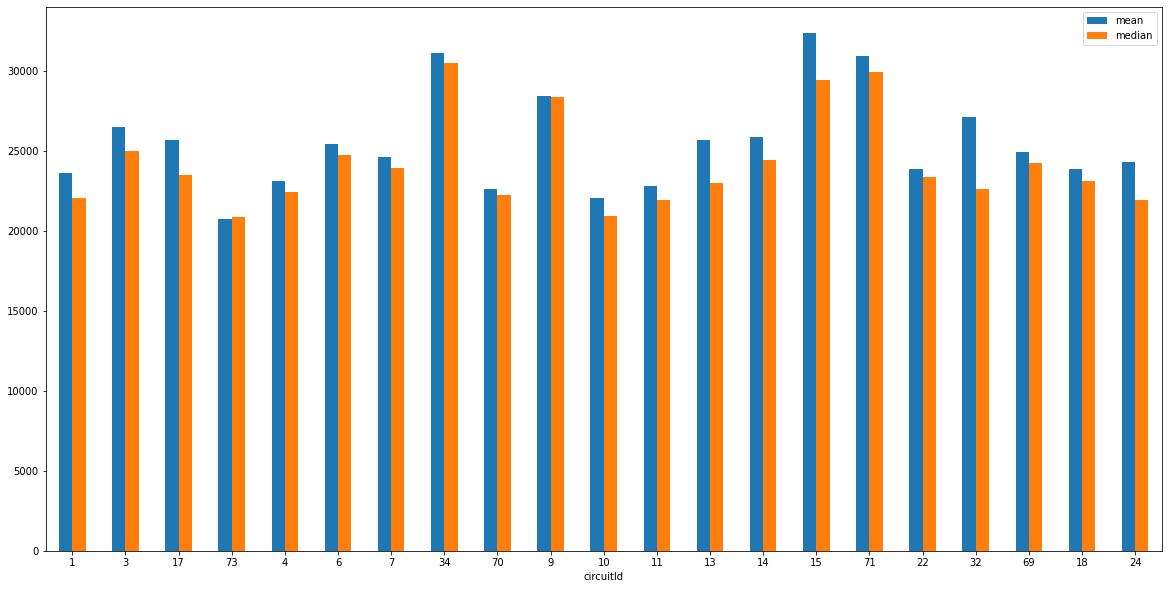

In [11]:
#read the 2019 csv

data2019 = pd.read_csv("2019.csv", encoding="ISO-8859-1")

grouped2019 = data2019.groupby('circuitId')['milliseconds'].agg(['mean', 'std', 'median']).reset_index()

data2019 = data2019.merge(grouped2019, on='circuitId')

data2019 = data2019[data2019.apply(remove_outliers, axis=1)]

data2019 = data2019.drop(['std'], axis=1)

#keep only circuitId and mean, but only one of each
data2019 = data2019.drop_duplicates(subset=['circuitId'])
data2019 = data2019[['circuitId', 'name', 'mean', 'median']].reset_index(drop=True)

#convert to seconds
mean2019 = data2019['mean'].div(1000).round(2)
median2019 = data2019['median'].div(1000).round(2)

#show the mean and median in bar graph together
data2019.plot.bar(x='circuitId', y=['mean', 'median'], rot=0, figsize=(20,10))

#real average is the average of the mean and median
data2019['real-average'] = (mean2019 + median2019) / 2

data2019['2019-average'] = data2019['real-average']

<Axes: ylabel='Density'>

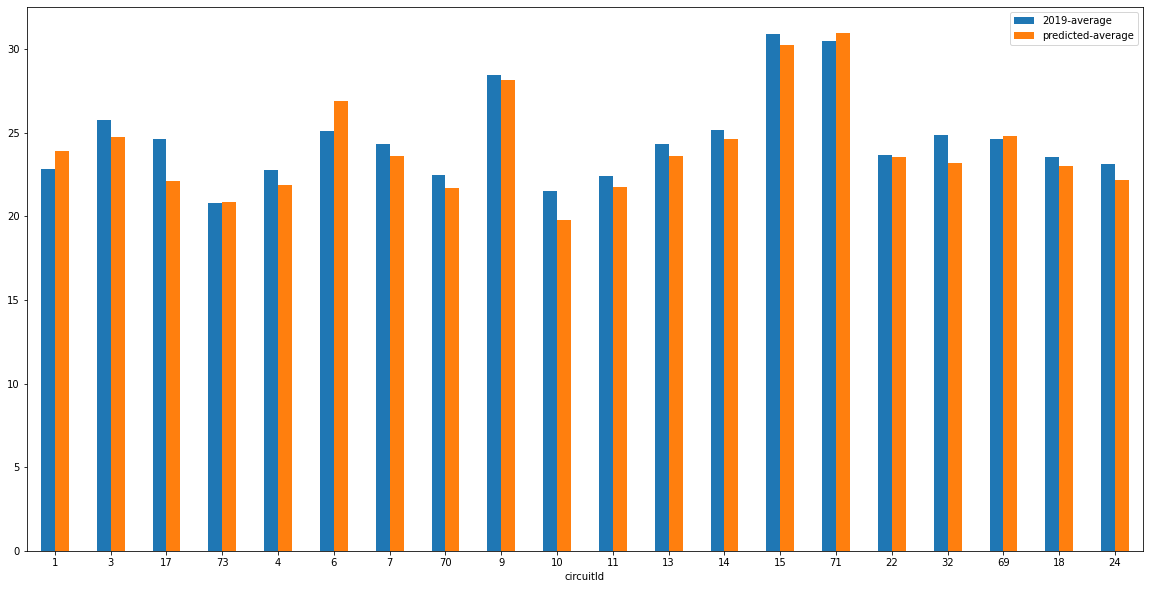

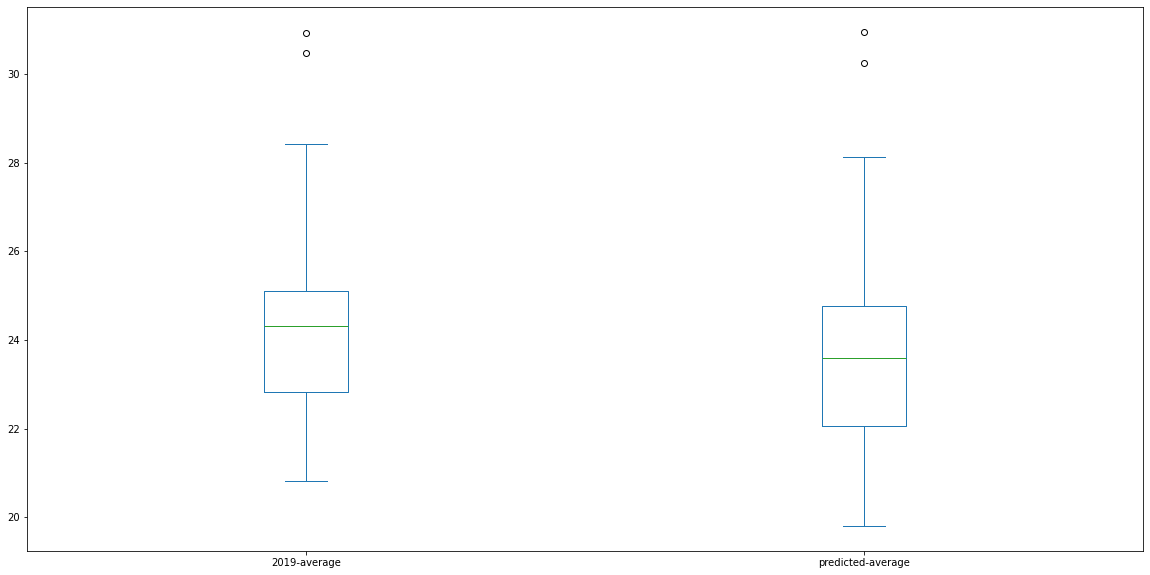

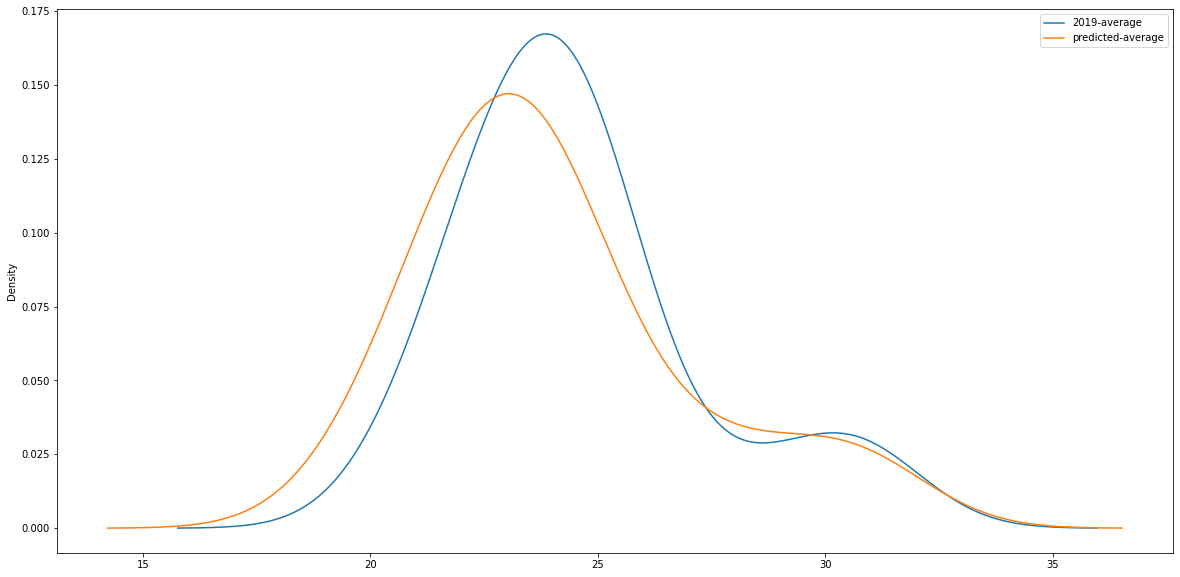

In [12]:
#we finally need to measure the accuracy of our model compared to the 2019 mean

#merge the two dataframes

merged = data2019.merge(track_averages, on='circuitId')

#show the difference between the two in a graph

merged

merged.plot.bar(x='circuitId', y=['2019-average', 'predicted-average'], rot=0, figsize=(20,10))

merged.plot.box(x='name_x', y=['2019-average', 'predicted-average'], rot=0, figsize=(20,10))

merged.plot.kde(x='name_x', y=['2019-average', 'predicted-average'], rot=0, figsize=(20,10))

In [13]:
#calculate the MAPE of the two

def mapeFunc(actual, predicted):
    return abs((actual - predicted) / actual).mean() * 100

mape = mapeFunc(merged['2019-average'], merged['predicted-average'])
mape

3.5666174496700362

In [14]:
#finally we need to measure the accuracy of our model compared to the 2019 mean

#we want to get it as a percentage for each track

merged['accuracy'] = (merged['2019-average'] / merged['predicted-average']).round(2)

#we need to find how close each accuaracy is to 1, given as a percentage, for above or below 1

merged['accuracy'] = merged['accuracy'].apply(lambda x: 1 - abs(1 - x))

#get the total accuracy as an average of all the tracks as a percentage, 2 decimal places

totalAccuracy = merged['accuracy'].mean() * 100

#show as string with % sign

(str(totalAccuracy.round(3)) + '%')

'96.35%'